In [4]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Paths
def find_root():
    if "__file__" in globals():
        return Path(__file__).resolve().parents[2]
    cwd = Path.cwd().resolve()
    for p in [cwd] + list(cwd.parents):
        if (p / "Results Datasets" / "final_analysis_dataset.parquet").exists():
            return p
    return cwd
ROOT = find_root()
DATA_PATH = ROOT / "Results Datasets" / "final_analysis_dataset.parquet"
OUT_ROOT = ROOT / "Results Datasets" / "analysis" / "phase1"
OUT_TABLES = OUT_ROOT / "tables"
OUT_VIS = OUT_ROOT / "visuals"
for d in [OUT_ROOT, OUT_TABLES, OUT_VIS]:
    d.mkdir(parents=True, exist_ok=True)

# --- Load data
if not DATA_PATH.exists():
    raise FileNotFoundError(DATA_PATH)

cols = None  # load all
_df = pd.read_parquet(DATA_PATH)
# Year filter
_df = _df[(_df["adve_time_year"] >= 2010) & (_df["adve_time_year"] <= 2024)].copy()

# Core columns
occ_exp_col = "occupation_exposure"
ind_exp_col = "industry_exposure_weighted"
occ_raw_col = "occu_isco_2008"  # raw ISCO
noga_col = "comp_indu_noga"

# Ensure numeric exposure
for col in [occ_exp_col, ind_exp_col]:
    _df[col] = pd.to_numeric(_df[col], errors="coerce")

# --- Labels (cross‑walks)
CW_DIR = ROOT / "External datasets" / "Cross-walks"

# NOGA labels
noga_map = {}
path_noga = CW_DIR / "comp_indu_noga_to_noga2digit_expanded.csv"
if path_noga.exists():
    noga = pd.read_csv(path_noga)
    noga["comp_indu_noga"] = pd.to_numeric(noga["comp_indu_noga"], errors="coerce")
    noga_map = (
        noga.dropna(subset=["comp_indu_noga"])
        .drop_duplicates(subset=["comp_indu_noga"])
        .set_index("comp_indu_noga")["label_de"].to_dict()
    )

# ISCO labels
isco1_map = {}
isco2_map = {}
path_isco1 = CW_DIR / "isco_major_code_to_label.csv"
path_isco2 = CW_DIR / "isco_08_submajor_2digit_code_to_label.csv"
if path_isco1.exists():
    t = pd.read_csv(path_isco1)
    t["isco_major"] = pd.to_numeric(t["isco_major"], errors="coerce")
    isco1_map = t.set_index("isco_major")["label_en"].to_dict()
if path_isco2.exists():
    t = pd.read_csv(path_isco2)
    t["isco_08_submajor_2d"] = pd.to_numeric(t["isco_08_submajor_2d"], errors="coerce")
    isco2_map = t.set_index("isco_08_submajor_2d")["label_en"].to_dict()

# Build raw ISCO string
isco_raw_str = _df[occ_raw_col].astype("string").str.split(".").str[0]
isco_raw_str = isco_raw_str.str.replace(r"[^0-9]", "", regex=True)
# zero-fill to 4 digits if numeric and length < 4
isco_raw_str = isco_raw_str.apply(lambda x: x.zfill(4) if x is not pd.NA and str(x).isdigit() and len(str(x)) < 4 else x)

major_placeholders = {"1000","2000","3000","4000","5000","6000","7000","8000","9000"}
isco_is_major_placeholder = isco_raw_str.isin(major_placeholders)

# Labels (do not add permanent new code columns to dataset; just build series)
isco1_label = isco_raw_str.str[:1].apply(lambda x: isco1_map.get(int(x)) if str(x).isdigit() else pd.NA)
isco2_label = isco_raw_str.apply(
    lambda x: "Unknown sub-major (major group only)" if x in major_placeholders else (
        isco2_map.get(int(str(x)[:2])) if str(x)[:2].isdigit() else pd.NA
    )
)

_df["comp_indu_noga_label"] = pd.to_numeric(_df[noga_col], errors="coerce").map(noga_map).astype("string")
_df["occu_isco1_label"] = isco1_label.astype("string")
_df["occu_isco2_label"] = isco2_label.astype("string")
_df["isco_is_major_placeholder"] = isco_is_major_placeholder

# Diagnostic table for placeholders
placeholder_counts = (
    pd.DataFrame({"isco_raw": isco_raw_str, "is_placeholder": isco_is_major_placeholder})
    .loc[isco_is_major_placeholder, "isco_raw"]
    .value_counts()
    .rename_axis("isco_raw")
    .reset_index(name="count")
)
placeholder_diag = pd.DataFrame({
    "total_rows": [len(_df)],
    "placeholder_rows": [isco_is_major_placeholder.sum()],
    "placeholder_share": [isco_is_major_placeholder.mean()],
})
placeholder_diag.to_csv(OUT_TABLES / "table_isco_placeholder_diagnostic.csv", index=False)

# Region labels (Unknown kept)
special_codes = {"-3","-7","-8","-9"}

canton_map = {
    1:"ZH",2:"BE",3:"LU",4:"UR",5:"SZ",6:"OW",7:"NW",8:"GL",9:"ZG",
    10:"FR",11:"SO",12:"BS",13:"BL",14:"SH",15:"AR",16:"AI",17:"SG",
    18:"GR",19:"AG",20:"TG",21:"TI",22:"VD",23:"VS",24:"NE",25:"GE",26:"JU"
}

def label_region(series, is_canton=False):
    raw = series.astype("string")
    lab = raw.where(~raw.isin(special_codes), other="Unknown")
    lab = lab.fillna("Unknown")
    if is_canton:
        def map_canton(val):
            if val == "Unknown" or pd.isna(val):
                return "Unknown"
            return canton_map.get(int(val), val) if str(val).isdigit() else val
        lab = lab.apply(map_canton)
    return lab.astype("string")

_df["loca_regi_kant_label"] = label_region(_df["loca_regi_kant"], is_canton=True)
_df["loca_regi_nuts_label"] = label_region(_df["loca_regi_nuts"], is_canton=False)

# Thresholds (global, unweighted)
occ_p80, occ_p90 = _df[occ_exp_col].quantile([0.8,0.9]).values
ind_p80, ind_p90 = _df[ind_exp_col].quantile([0.8,0.9]).values

# Coverage (tru2-weighted)
tru2_total = _df["srvy_wght_tru2"].sum()
occ_cov_tru2 = _df.loc[_df[occ_exp_col].notna(), "srvy_wght_tru2"].sum() / tru2_total
ind_cov_tru2 = _df.loc[_df[ind_exp_col].notna(), "srvy_wght_tru2"].sum() / tru2_total

# Unknown region share (tru2)
unknown_kant_share = _df.loc[_df["loca_regi_kant_label"] == "Unknown", "srvy_wght_tru2"].sum() / tru2_total
unknown_nuts_share = _df.loc[_df["loca_regi_nuts_label"] == "Unknown", "srvy_wght_tru2"].sum() / tru2_total

summary = {
    "thresholds": {
        "occ_p80": float(occ_p80), "occ_p90": float(occ_p90),
        "ind_p80": float(ind_p80), "ind_p90": float(ind_p90),
    },
    "coverage_tru2": {"occ": float(occ_cov_tru2), "ind": float(ind_cov_tru2)},
    "unknown_region_share_tru2": {"kanton": float(unknown_kant_share), "nuts": float(unknown_nuts_share)},
    "scatter_label_strategy": "labels = top 10 by demand + top 10 by mean exposure + top 10 by exposed demand (+ optional lowest exposure); deduplicated",
}

(OUT_ROOT / "phase1_summary.json").write_text(json.dumps(summary, indent=2))
summary


{'thresholds': {'occ_p80': 1.2383682999999999,
  'occ_p90': 1.284863,
  'ind_p80': -0.11150409999999998,
  'ind_p90': 0.02903156181818183},
 'coverage_tru2': {'occ': 0.9183896392364413, 'ind': 0.8634745722247269},
 'unknown_region_share_tru2': {'kanton': 0.060835489601052714,
  'nuts': 0.060835489601052714},
 'scatter_label_strategy': 'labels = top 10 by demand + top 10 by mean exposure + top 10 by exposed demand (+ optional lowest exposure); deduplicated'}

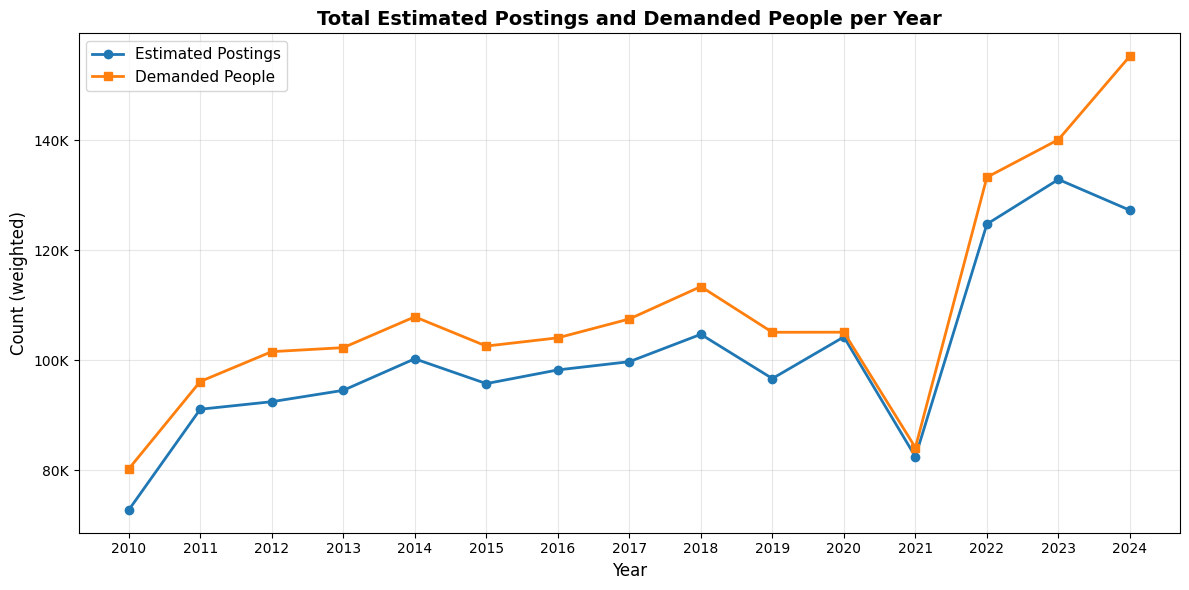


Yearly Summary:
 year  estimated_postings  demanded_people
 2010          72730.7017       80201.1171
 2011          91055.1722       96098.3044
 2012          92425.5602      101527.7178
 2013          94492.2162      102255.5986
 2014         100227.6535      107862.6531
 2015          95716.8056      102542.0088
 2016          98204.9033       104038.788
 2017           99701.576      107467.6759
 2018         104677.2332      113359.3204
 2019          96636.5573      105048.6306
 2020         104206.8669      105065.0702
 2021          82419.4839       84080.8777
 2022         124719.8247      133237.5833
 2023         132839.1517      140083.1894
 2024         127233.0193      155278.3121

Total estimated postings (2010-2024): 1,517,287
Total demanded people (2010-2024): 1,638,147

Saved to: /Users/miguel/Documents/Master Thesis/Thesis/Results Datasets/analysis/phase1/tables/yearly_postings_and_demand.csv


In [8]:
# Calculate yearly totals for postings and demanded people
yearly_stats = _df.groupby("adve_time_year").agg({
    "srvy_wght_tru1": "sum",  # Weighted postings
    "srvy_wght_tru2": "sum",  # Weighted demanded people
}).reset_index()
yearly_stats.columns = ["year", "estimated_postings", "demanded_people"]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot both series
ax.plot(yearly_stats["year"], yearly_stats["estimated_postings"], 
        marker="o", label="Estimated Postings", linewidth=2, markersize=6)
ax.plot(yearly_stats["year"], yearly_stats["demanded_people"], 
        marker="s", label="Demanded People", linewidth=2, markersize=6)

ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Count (weighted)", fontsize=12)
ax.set_title("Total Estimated Postings and Demanded People per Year", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xticks(yearly_stats["year"])

# Format y-axis to show numbers in millions or thousands
max_val = max(yearly_stats["estimated_postings"].max(), yearly_stats["demanded_people"].max())
if max_val >= 1e6:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
elif max_val >= 1e3:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e3:.0f}K'))

plt.tight_layout()
plt.savefig(OUT_VIS / "yearly_postings_and_demand.png", dpi=300, bbox_inches="tight")
plt.show()

# Print summary statistics
print("\nYearly Summary:")
print(yearly_stats.to_string(index=False))
print(f"\nTotal estimated postings (2010-2024): {yearly_stats['estimated_postings'].sum():,.0f}")
print(f"Total demanded people (2010-2024): {yearly_stats['demanded_people'].sum():,.0f}")

# Save to CSV
yearly_stats.to_csv(OUT_TABLES / "yearly_postings_and_demand.csv", index=False)
print(f"\nSaved to: {OUT_TABLES / 'yearly_postings_and_demand.csv'}")

In [ ]:
# Average exposure per year (occupation and industry)# Compute simple yearly meansexposure_yearly = (    _df.groupby("adve_time_year")[["occupation_exposure", "industry_exposure_weighted"]]       .mean(numeric_only=True)       .reset_index()       .rename(columns={"adve_time_year": "year",                         "occupation_exposure": "avg_occ_exposure",                         "industry_exposure_weighted": "avg_ind_exposure"}))fig, ax = plt.subplots(figsize=(10, 5))ax.plot(exposure_yearly["year"], exposure_yearly["avg_occ_exposure"], marker="o", label="Occupation exposure (avg)")ax.plot(exposure_yearly["year"], exposure_yearly["avg_ind_exposure"], marker="s", label="Industry exposure (avg)")ax.set_title("Average Exposure per Year")ax.set_xlabel("Year")ax.set_ylabel("Average exposure")ax.legend()ax.grid(True, alpha=0.3)ax.set_xticks(exposure_yearly["year"])plt.tight_layout()plt.savefig(OUT_VIS / "yearly_average_exposure_occ_ind.png", dpi=300, bbox_inches="tight")plt.show()print("Average exposure per year:")print(exposure_yearly.to_string(index=False))exposure_yearly.to_csv(OUT_TABLES / "yearly_average_exposure_occ_ind.csv", index=False)print(f"Saved to: {OUT_TABLES / 'yearly_average_exposure_occ_ind.csv'}")